**Goal:** The notebook processes parser result to output [ReactFlow]() compatible `node.json` and `edge.json` with auto layout which can be directly used to generate notebook graph.

Some steps we will go through in this notebook:
1. Extract all the features from the `arguments` column
2. Construct tree(s) using `networkx` by merging similar "variable path"
   1. e.g. Attrition -> YearsWithCurrManager and Attrition -> YearsWithCurrManager -> MonthlyIncome should be "merged into a tree
3. Construct nodes and edges based on the constructed trees

Note: we'll use `networkx` package to construct an intermediary graph first to hold all the needed data.

In [287]:
import numpy as np
import pandas as pd
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
import json
import re

In [288]:
df = pd.read_csv('./NB1-Attrition-smi.csv')
df.head()

,cell_id,line_no,code,module_name,func_name,arguments,dataframe,plottype,program_slice
0,6,0,"sb.catplot(y=""Attrition"", data=employee, kind=...",seaborn,catplot,"{'x': '', 'y': 'Attrition', 'hue': '', 'col': ...",<employee>,count,"{'data': [(0, 0), (1, 0)]}"
1,24,1,"sb.swarmplot(x = 'Attrition', y = 'Age', data ...",seaborn,swarmplot,"{'x': 'Attrition', 'y': 'Age', 'hue': ''}",<employee>,swarm,"{'data': [(0, 0), (1, 0), (8, 0), (9, 0), (12,..."
2,25,1,"sb.swarmplot(x = 'Attrition', y = 'YearsWithCu...",seaborn,swarmplot,"{'x': 'Attrition', 'y': 'YearsWithCurrManager'...",<employee>,swarm,"{'data': [(0, 0), (1, 0), (8, 0), (9, 0), (12,..."
3,27,2,"sb.catplot(y = var, data = attrition, kind = ""...",seaborn,catplot,"{'x': '', 'y': 'RelationshipSatisfaction', 'hu...",<attrition>,count,"{'data': [(0, 0), (1, 0), (8, 0), (9, 0), (12,..."
4,27,2,"sb.catplot(y = var, data = attrition, kind = ""...",seaborn,catplot,"{'x': '', 'y': 'Attrition', 'hue': '', 'col': ...",<attrition>,count,"{'data': [(0, 0), (1, 0), (8, 0), (9, 0), (12,..."


## 1. Extract all variables (i.e. nodes)

In [289]:
var_nodes = set() # set(str)
var_edges = set() # set(tuple)
var_paths = []
vars_freq = {}

# convert df to ndarray (row-major) for faster iterations over rows (pd is column-major)
df_arg_np = df["arguments"].to_numpy()
for i, row in enumerate(df_arg_np):
    # replacing single quote with double quote to match json.loads() requirement
    row = re.sub(r"\'", "\"", row)
    row_dict = dict(json.loads(row))

    # construct a variable path/combination
    var_path = []
    for (k,v) in row_dict.items():
        if v != '':
            var_nodes.add(v)
            vars_freq[v] = vars_freq.get(v, 0) + 1
            var_path.append(v)
    var_paths.append(var_path)
    
    # parse the variable path into a list of tuples e.g. ["OverTime", "Attrition", "MonthlyIncome"] -> [("OverTime", "Attrition"), ("Attrition", "MonthlyIncome")]
    temp_edges = [(var_path[i], var_path[i+1]) for i in range(len(var_path)-1)]
    for e in temp_edges:
        var_edges.add(e)


In [290]:
print(f"In total we have {len(var_nodes)} unique variable nodes.")
print(f"In total we have {len(var_nodes)} unique variable edges.")
print(var_nodes)
print(var_edges)

In total we have 22 unique variable nodes.
In total we have 22 unique variable edges.
{'StockOptionLevel', 'JobRole', 'Education', 'JobSatisfaction', 'Over18', 'Predictors', 'TotalWorkingYears', 'RelationshipSatisfaction', 'Department', 'EducationField', 'MaritalStatus', 'MonthlyIncome', 'Importance', 'YearsInCurrentRole', 'YearsWithCurrManager', 'JobInvolvement', 'YearsAtCompany', 'JobLevel', 'Age', 'Attrition', 'OverTime', 'Stock_0'}
{('JobSatisfaction', 'OverTime'), ('JobSatisfaction', 'MonthlyIncome'), ('OverTime', 'MonthlyIncome'), ('Department', 'MonthlyIncome'), ('StockOptionLevel', 'JobLevel'), ('Attrition', 'JobSatisfaction'), ('MonthlyIncome', 'JobRole'), ('Department', 'StockOptionLevel'), ('Attrition', 'YearsInCurrentRole'), ('Attrition', 'MonthlyIncome'), ('JobRole', 'StockOptionLevel'), ('JobInvolvement', 'MonthlyIncome'), ('MonthlyIncome', 'OverTime'), ('MonthlyIncome', 'StockOptionLevel'), ('Attrition', 'JobLevel'), ('YearsAtCompany', 'Department'), ('Importance', 'Pred

In [291]:
# Sort vars_freq and we see Attrition, as a variable node appears the highest number of times then it's more likely to be a root tree
vars_freq_series = pd.Series(vars_freq).sort_values(ascending=False)
vars_freq_series[:5]

Attrition           23
MonthlyIncome       16
JobLevel             8
StockOptionLevel     7
JobRole              6
dtype: int64

graph nodes: ['StockOptionLevel', 'JobRole', 'Education', 'JobSatisfaction', 'Over18', 'Predictors', 'TotalWorkingYears', 'RelationshipSatisfaction', 'Department', 'EducationField', 'MaritalStatus', 'MonthlyIncome', 'Importance', 'YearsInCurrentRole', 'YearsWithCurrManager', 'JobInvolvement', 'YearsAtCompany', 'JobLevel', 'Age', 'Attrition', 'OverTime', 'Stock_0']
graph edges: [('StockOptionLevel', 'JobLevel'), ('StockOptionLevel', 'Attrition'), ('StockOptionLevel', 'MonthlyIncome'), ('JobRole', 'StockOptionLevel'), ('JobSatisfaction', 'OverTime'), ('JobSatisfaction', 'MonthlyIncome'), ('Department', 'MonthlyIncome'), ('Department', 'StockOptionLevel'), ('MonthlyIncome', 'JobRole'), ('MonthlyIncome', 'OverTime'), ('MonthlyIncome', 'StockOptionLevel'), ('MonthlyIncome', 'Attrition'), ('Importance', 'Predictors'), ('JobInvolvement', 'MonthlyIncome'), ('YearsAtCompany', 'Department'), ('YearsAtCompany', 'JobRole'), ('YearsAtCompany', 'MonthlyIncome'), ('JobLevel', 'MonthlyIncome'), ('Attr

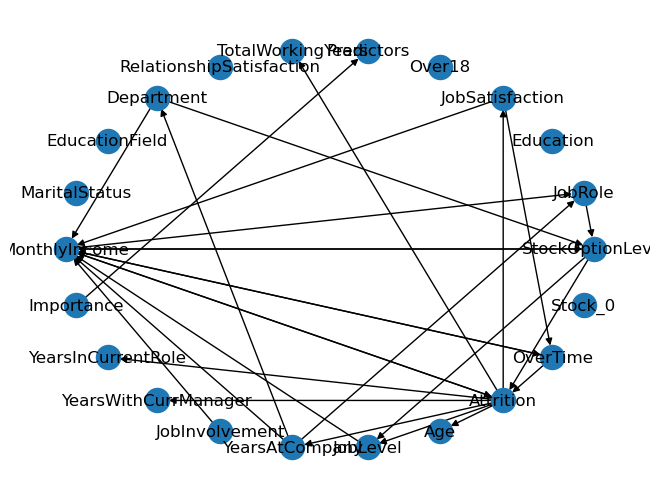

In [292]:
# 2. Construct variable combination tree using `networkx` by merging similar "variable path"

# creating a graph first and add all variables as nodes
G = nx.DiGraph()
G.add_nodes_from(var_nodes)
G.add_edges_from(var_edges)
print(f'graph nodes: {G.nodes}')
print(f'graph edges: {G.edges}')
pos = nx.circular_layout(G)
# pos = nx.kamada_kawai_layout(G)
# pos = graphviz_layout(G, prog="dot")
nx.draw(G, pos, with_labels=True)
plt.show()


## 2. Construct tree(s) using `networkx` by merging similar "variable path" (Rough Algorithm)
e.g. Attrition -> YearsWithCurrManager and Attrition -> YearsWithCurrManager -> MonthlyIncome should be "merged into a tree

### First Try

In [293]:
# creating a directed graph and add all variables as nodes

# except that this time we sort the variable based on its frequency in a descending order
var_edges_sorted = set()
var_nodes_new = var_nodes.copy()
for var_path in var_paths:
    # sort the path based on the frequency of each node
    # *in case of equal frequency sort in alphabetical order
    freq = [vars_freq[v] for v in var_path]
    var_path_sorted = [x for _,x in sorted(zip(freq, var_path), reverse=True)]

    # if var_path_sorted != var_path:
    #     print(f"Original path: {list(zip(var_path, freq))}")
    #     print(f"Sorted path: {var_path_sorted}")

    # parse the variable path into a list of tuples e.g. ["OverTime", "Attrition", "MonthlyIncome"] -> [("OverTime", "Attrition"), ("Attrition", "MonthlyIncome")]
    temp_edges = [(var_path_sorted[i], var_path_sorted[i+1]) for i in range(len(var_path_sorted)-1)]
    for e in temp_edges:
        var_edges_sorted.add(e)


In total we have 23 unique variable nodes.
In total we have 32 unique variable edges.
graph nodes: ['StockOptionLevel', 'JobRole', 'Education', 'EducationField', 'MaritalStatus', 'MonthlyIncome', 'Importance', 'JobSatisfaction', 'YearsInCurrentRole', 'YearsWithCurrManager', 'JobInvolvement', 'YearsAtCompany', 'JobLevel', 'Over18', 'Predictors', 'Age', 'TotalWorkingYears', 'Attrition', 'OverTime', 'RelationshipSatisfaction', 'Stock_0', 'Department', 'Root']
graph edges: [('StockOptionLevel', 'YearsAtCompany'), ('StockOptionLevel', 'JobRole'), ('JobRole', 'YearsAtCompany'), ('MonthlyIncome', 'JobSatisfaction'), ('MonthlyIncome', 'OverTime'), ('MonthlyIncome', 'StockOptionLevel'), ('MonthlyIncome', 'JobLevel'), ('MonthlyIncome', 'JobInvolvement'), ('MonthlyIncome', 'Department'), ('YearsAtCompany', 'Department'), ('JobLevel', 'JobRole'), ('JobLevel', 'StockOptionLevel'), ('Predictors', 'Importance'), ('Attrition', 'YearsInCurrentRole'), ('Attrition', 'MonthlyIncome'), ('Attrition', 'Stock

/tmp/ipykernel_1103/27025385.py:20: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="dot")


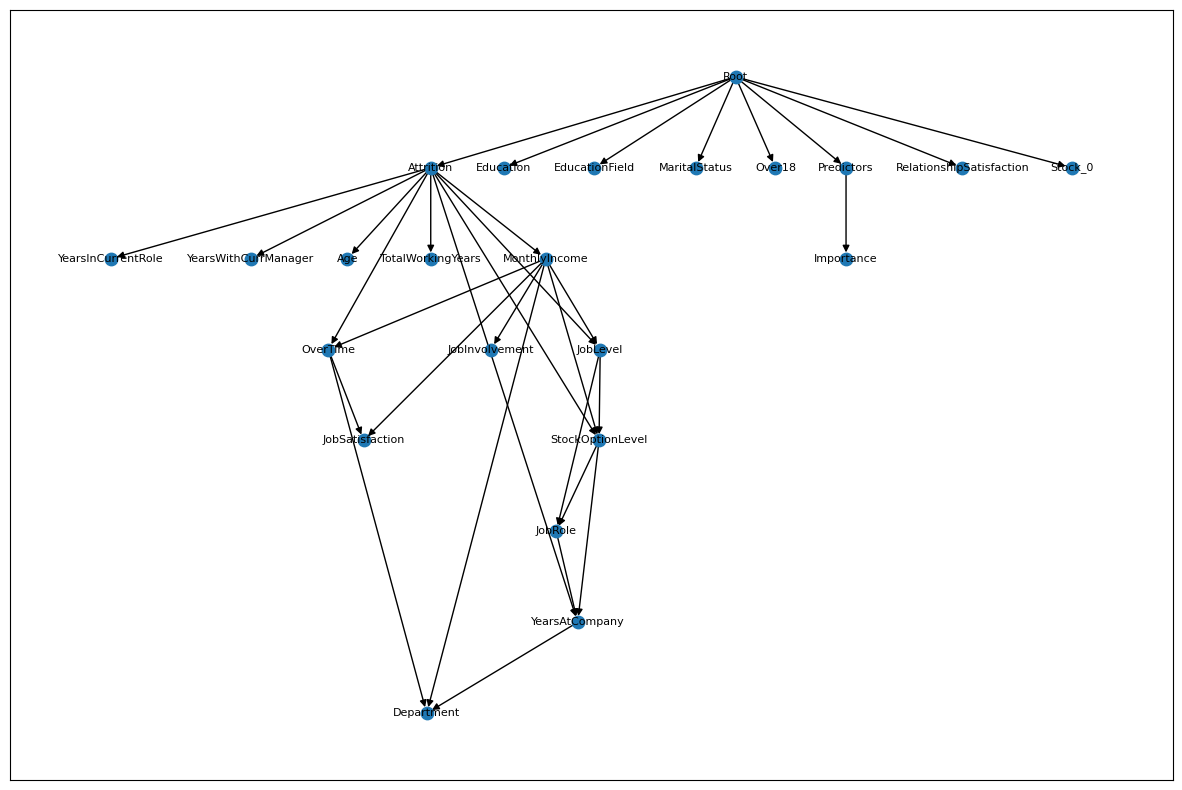

In [311]:
G = nx.DiGraph()
G.add_nodes_from(var_nodes_new)
G.add_edges_from(var_edges_sorted)

# Add a root node with edges to all the "lone nodes" (i.e. single node with zero in-degree)
G.add_node("Root")
for node in G.nodes:
    # print("Node is: ", node, " and in-degree is: ", G.in_degree(node))
    # print(f"List all in-degree edges of {node}: ", G.in_edges(node))
    if node != "Root" and G.in_degree(node) == 0:
        # print(f"adding edge from Root to {node}: ", ("Root", node))
        G.add_edge("Root", node)

print(f"In total we have {len(G.nodes)} unique variable nodes.")
print(f"In total we have {len(G.edges)} unique variable edges.")
print(f'graph nodes: {G.nodes}')
print(f'graph edges: {G.edges}')
# pos = nx.circular_layout(G)
# pos = nx.kamada_kawai_layout(G)
pos = graphviz_layout(G, prog="dot")

# make the figure bigger
plt.figure(figsize=(15,10))
nx.draw_networkx(
    G,
    pos,
    node_size=80,
    font_size=8,
    with_labels=True)
plt.show()

The problem with this approach is that it includes each variable only once and won't be able to capture an independent path like (Root -> MonthlyIncome -> JobInvolvement) since MonthlyIncome -> JobInvolvement is merged as part of Attrition.

The point is we need duplicated nodes not unique nodes to produce a tree.

/tmp/ipykernel_1103/2956075503.py:2: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="dot")


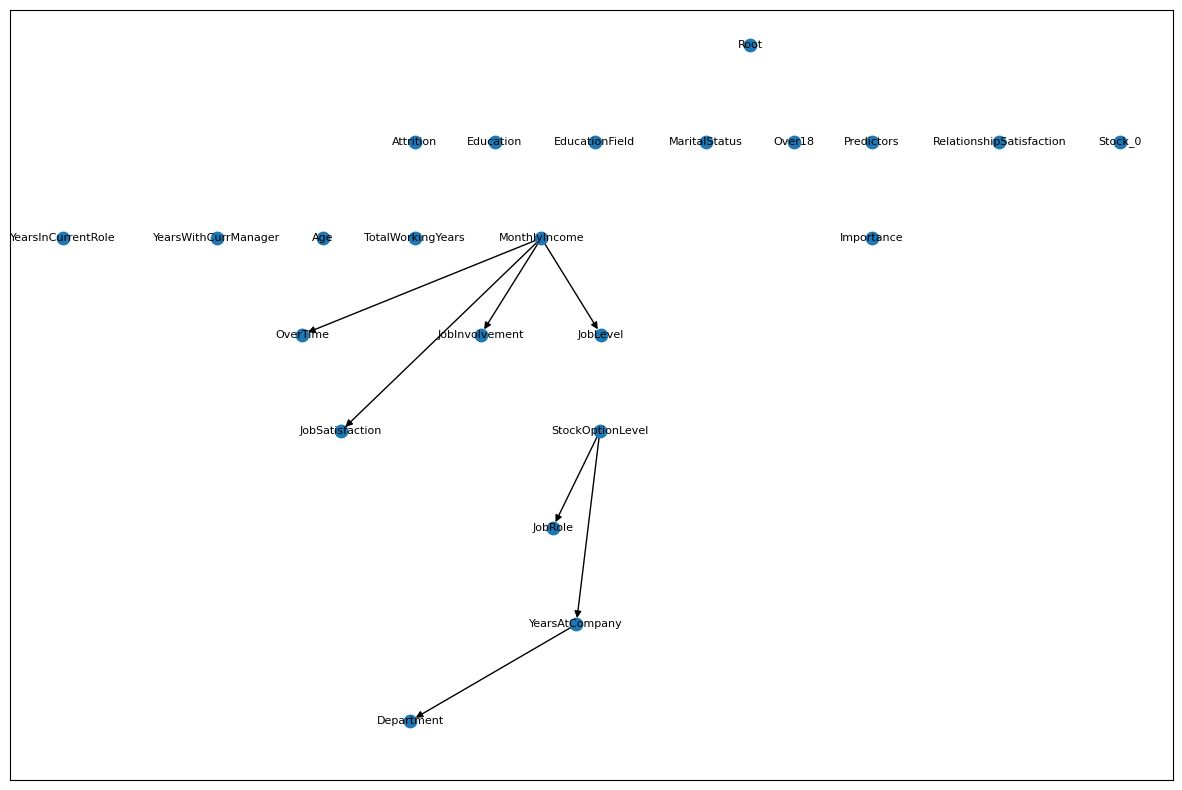

In [309]:
T = nx.dfs_tree(G)
pos = graphviz_layout(G, prog="dot")
plt.figure(figsize=(15,10))
nx.draw_networkx(
    T,
    pos,
    node_size=80,
    font_size=8,
    with_labels=True)
plt.show()

### Second Try

In [315]:
# creating a directed graph and add all variables as nodes
G = nx.DiGraph()
G.add_node("Root")

# except that this time we sort the variable based on its frequency in a descending order
for var_path in var_paths:
    # sort the path based on the frequency of each node
    # *in case of equal frequency sort in reversed alphabetical order
    freq = [vars_freq[v] for v in var_path]
    var_path_sorted = [x for _,x in sorted(zip(freq, var_path), reverse=True)]

    # parse the variable path into a list of tuples e.g. ["OverTime", "Attrition", "MonthlyIncome"] -> [("OverTime", "Attrition"), ("Attrition", "MonthlyIncome")]
    temp_edges = [("Root", var_path_sorted[0])]
    temp_edges += [(var_path_sorted[i], var_path_sorted[i+1]) for i in range(len(var_path_sorted)-1)]
    for (source, target) in temp_edges:
        has_path = False
        try:
            has_path = nx.has_path(G, source, target)
        except nx.NodeNotFound as ne:
            G.add_node(source)
            G.add_node(target)
            G.add_edge(source, target)
        if not has_path:
            # do something
            continue
        # Note: we might need to add suffix to the node name to avoid duplicate node names        

NodeNotFound: Either source Root or target Attrition is not in G

In total we have 23 unique variable nodes.
In total we have 34 unique variable edges.
graph nodes: ['StockOptionLevel', 'JobRole', 'Education', 'EducationField', 'MaritalStatus', 'MonthlyIncome', 'Importance', 'JobSatisfaction', 'YearsInCurrentRole', 'YearsWithCurrManager', 'JobInvolvement', 'YearsAtCompany', 'JobLevel', 'Over18', 'Predictors', 'Age', 'TotalWorkingYears', 'Attrition', 'OverTime', 'RelationshipSatisfaction', 'Stock_0', 'Department', 'Root']
graph edges: [('StockOptionLevel', 'JobRole'), ('StockOptionLevel', 'YearsAtCompany'), ('JobRole', 'YearsAtCompany'), ('MonthlyIncome', 'Department'), ('MonthlyIncome', 'JobSatisfaction'), ('MonthlyIncome', 'OverTime'), ('MonthlyIncome', 'JobLevel'), ('MonthlyIncome', 'StockOptionLevel'), ('MonthlyIncome', 'JobInvolvement'), ('YearsAtCompany', 'Department'), ('JobLevel', 'JobRole'), ('JobLevel', 'StockOptionLevel'), ('Predictors', 'Importance'), ('Attrition', 'Age'), ('Attrition', 'YearsWithCurrManager'), ('Attrition', 'MonthlyIncome

/tmp/ipykernel_1103/3202291404.py:7: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="dot")


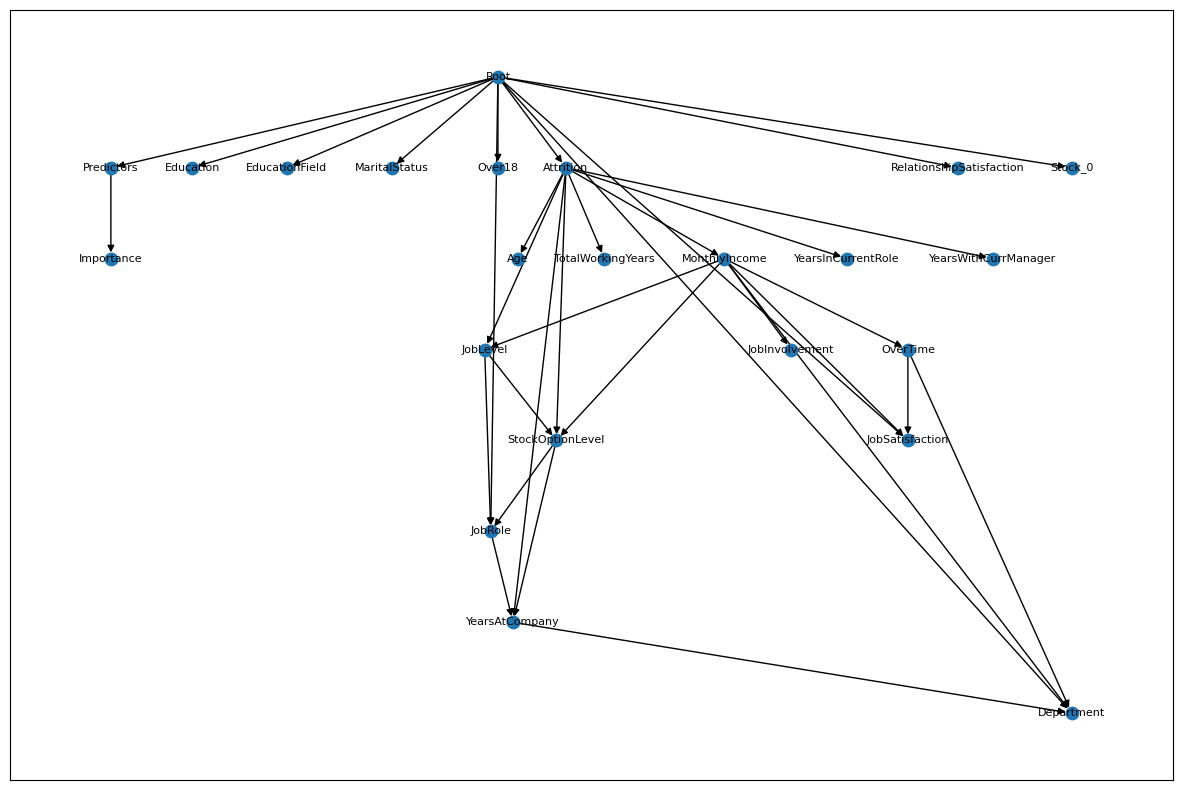

In [314]:
print(f"In total we have {len(G.nodes)} unique variable nodes.")
print(f"In total we have {len(G.edges)} unique variable edges.")
print(f'graph nodes: {G.nodes}')
print(f'graph edges: {G.edges}')
# pos = nx.circular_layout(G)
# pos = nx.kamada_kawai_layout(G)
pos = graphviz_layout(G, prog="dot")

# make the figure bigger
plt.figure(figsize=(15,10))
nx.draw_networkx(
    G,
    pos,
    node_size=80,
    font_size=8,
    with_labels=True)
plt.show()

## 3. Construct nodes and edges based on the constructed trees